<a href="https://colab.research.google.com/github/afdmoraes/GEOSelper/blob/main/Semana_4_Aula_3_An%C3%A1lise_de_Imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de Programação para Sensoriamento Remoto
---

* Gilberto Ribeiro de Queiroz
* Thales Sehn Körting

## Tópicos desta aula

* Visualização de imagens com NumPy e Matplotlib
* Análise de imagens com GDAL e NumPy



# Visualização de imagens
---

Primeiramente, vamos criar os objetos que nos darão acesso aos elementos da imagem:
* dataset 
* bandas individuais
* array de pixels (formato NumPy)

In [ ]:
# importar bibliotecas
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

# informar o uso de exceções
gdal.UseExceptions()

# abrir o dataset da imagem RapidEye, com 5 bandas
# (lembre-se de fazer o upload na aba de arquivos)
dataset = gdal.Open("crop_rapideye.tif", gdal.GA_ReadOnly)

# obter os objetos com as informações das bandas
banda1 = dataset.GetRasterBand(1) # banda blue
banda2 = dataset.GetRasterBand(2) # banda green
banda3 = dataset.GetRasterBand(3) # banda red
banda4 = dataset.GetRasterBand(4) # banda red-edge
banda5 = dataset.GetRasterBand(5) # banda nir

# imprimir informações de máximos/mínimos 
# valores dos pixels de cada banda
print(banda1.ComputeRasterMinMax())
print(banda2.ComputeRasterMinMax())
print(banda3.ComputeRasterMinMax())
print(banda4.ComputeRasterMinMax())
print(banda5.ComputeRasterMinMax())

(0.0, 18381.0)
(0.0, 18851.0)
(0.0, 20693.0)
(0.0, 16055.0)
(0.0, 17264.0)


Uma maneira muito utilizada para complementar a visualização das imagens é através do histograma. Ele apresenta de forma gráfica a distribuição dos pixels na imagem. A GDAL armazena esta informação em cada banda, e podemos acessar o histograma através da função `GetHistogram`.

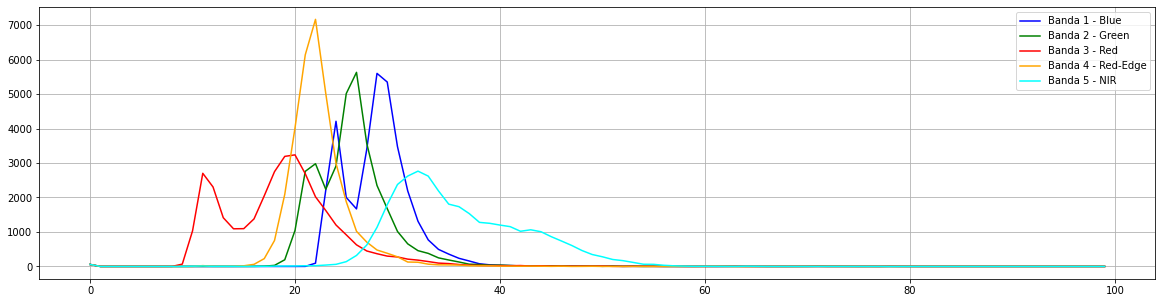

In [ ]:
# a função GetHistogram precisa de intervalos
# mínimos e máximos de pixels para cada banda (min/max)
# e também a informação de divisões do gráfico (buckets)
plt.figure(figsize=(20, 5))
plt.plot(banda1.GetHistogram(min=0, max=25000, buckets=100), 'b', label='Banda 1 - Blue')
plt.plot(banda2.GetHistogram(min=0, max=25000, buckets=100), 'g', label='Banda 2 - Green')
plt.plot(banda3.GetHistogram(min=0, max=25000, buckets=100), 'r', label='Banda 3 - Red')
plt.plot(banda4.GetHistogram(min=0, max=25000, buckets=100), 'orange', label='Banda 4 - Red-Edge')
plt.plot(banda5.GetHistogram(min=0, max=25000, buckets=100), 'cyan', label='Banda 5 - NIR')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Banda 5 - NIR')

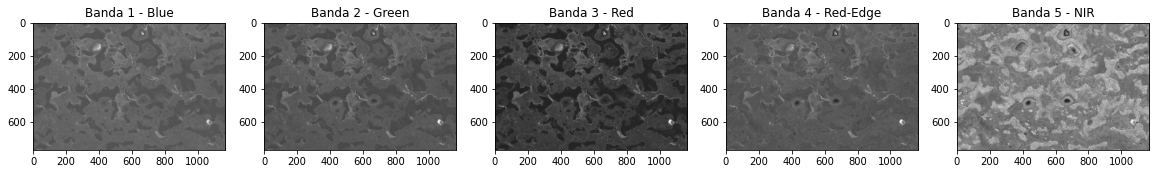

In [ ]:
# obter as matrizes de pixels de cada banda
blue = banda1.ReadAsArray()
green = banda2.ReadAsArray()
red = banda3.ReadAsArray()
rededge = banda4.ReadAsArray()
nir = banda5.ReadAsArray()

# combinamos GDAL e Matplotlib para
# visualizar as bandas individualmente
plt.figure(figsize=(20, 5))
plt.subplot(151)
plt.imshow(blue, cmap='gray')
plt.title('Banda 1 - Blue')
plt.subplot(152)
plt.imshow(green, cmap='gray')
plt.title('Banda 2 - Green')
plt.subplot(153)
plt.imshow(red, cmap='gray')
plt.title('Banda 3 - Red')
plt.subplot(154)
plt.imshow(rededge, cmap='gray')
plt.title('Banda 4 - Red-Edge')
plt.subplot(155)
plt.imshow(nir, cmap='gray')
plt.title('Banda 5 - NIR')

Podemos combinar a visualização de 2 bandas em um gráfico comumente chamado de *scatterplot*. Para isso precisamos transformar as bandas da nossa imagem (2 dimensões) em vetores (1 dimensão). Para isso podemos usar a função da NumPy chamada `flatten`.

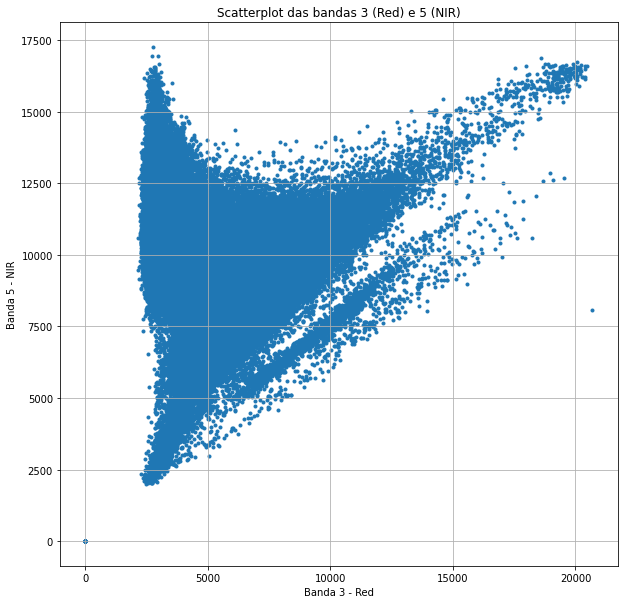

In [ ]:
# obter os vetores de 1 dimensão de cada banda
vetor3 = red.flatten()
vetor5 = nir.flatten()

# construir o gráfico com o scatterplot
plt.figure(figsize=(10, 10))

plt.scatter(vetor3, vetor5, marker='.')
plt.xlabel("Banda 3 - Red")
plt.ylabel("Banda 5 - NIR")
plt.title("Scatterplot das bandas 3 (Red) e 5 (NIR)")
plt.grid();

# Composição colorida e Contraste
---

Para visualizar uma composição colorida, precisamos informar quais bandas serão utilizadas nas componentes RGB do gráfico:
* canal R (vermelho)
* canal G (verde)
* canal B (azul)

Para isso, podemos criar uma matriz NumPy com 3 dimensões (linhas, colunas, bandas).

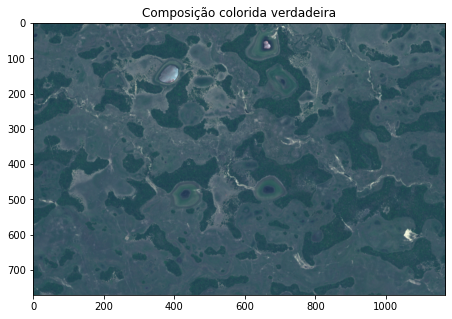

In [ ]:
# definimos os números de linhas/colunas
# a partir de alguma matriz da imagem original
linhas = blue.shape[0]
colunas = blue.shape[1]
bandas = 3

# para criar uma visualização em cores 
# verdadeiras, podemos associar as bandas
# do RapidEye 3 - Red, 2 - Green, 1 - Blue 
array_rgb = np.zeros((linhas, colunas, bandas))

# veja que, para visualizar corretamente,
# precisaremos dividir as matrizes pelo
# maior valor, para obtermos uma matriz
# com valores normalizados entre 0.0 e 1.0
array_rgb[:, :, 0] = red / red.max()
array_rgb[:, :, 1] = green / green.max()
array_rgb[:, :, 2] = blue / blue.max()

plt.figure(figsize=(20, 5))
plt.imshow(array_rgb)
plt.title('Composição colorida verdadeira');

O contraste é uma técnica que melhora a visualização da imagem. Veja que neste caso, os números digitais da imagem podem ser alterados, e assim as propriedades dos elementos em relação a suas respostas espectrais ficam comprometidas. 

**Atenção:** Para realizar análises baseadas no comportamento espectral das imagens, técnicas de contraste devem ser evitadas.

Uma maneira bem conhecida de aplicar o contraste é através das operações de *gain* (ganho) e *offset* (deslocamento). O *gain* é um valor constante que é **multiplicado** por todos os pixels das imagens. O *offset* é um valor constante que é **somado** a todos os pixels das imagens. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


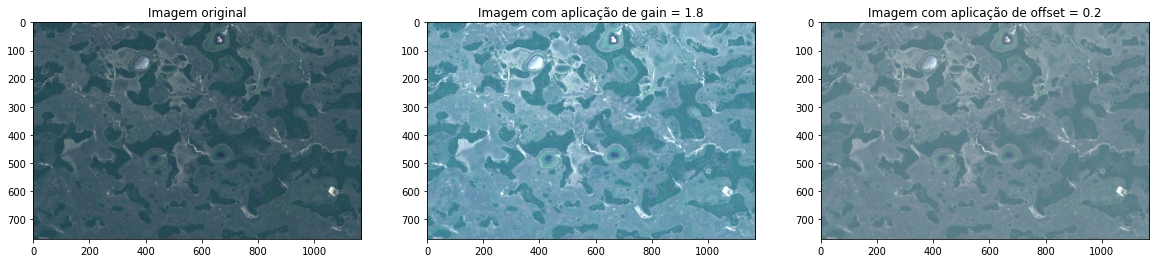

In [ ]:
# lembrando que os valores em array_rgb
# foram normalizados entre 0.0 e 1.0
gain = 1.8
offset = 0.2

# como no exemplo anterior criamos um
# array_rgb, vamos alterar uma cópia deste
# array com as operações de gain/offset
# para não comprometer os dados originais
array_rgb_gain = array_rgb.copy()
array_rgb_gain[:, :, 0] *= gain
array_rgb_gain[:, :, 1] *= gain
array_rgb_gain[:, :, 2] *= gain

# podemos aplicar gain/offset ao mesmo tempo
# e também sobre a(s) banda(s) que desejarmos
# para entender os efeitos, vamos aplicar
# cada um separadamente
array_rgb_offset = array_rgb.copy()
array_rgb_offset[:, :, 0] += offset
array_rgb_offset[:, :, 1] += offset
array_rgb_offset[:, :, 2] += offset

# apresentação dos resultados
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow(array_rgb)
plt.title(f'Imagem original');

plt.subplot(132)
plt.imshow(array_rgb_gain)
plt.title(f'Imagem com aplicação de gain = {gain}');

plt.subplot(133)
plt.imshow(array_rgb_offset)
plt.title(f'Imagem com aplicação de offset = {offset}');

# Métodos simples para classificação
---

Em diversos casos, a aplicação de limiares sobre índices espectrais produz rapidamente resultados de mapeamento de alvos.

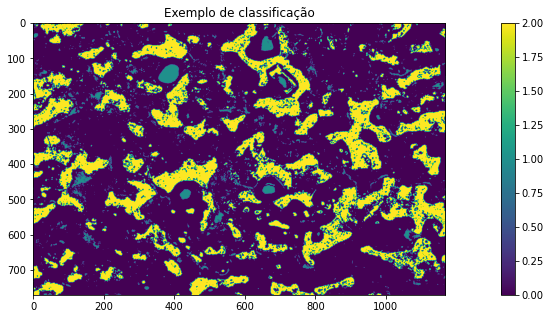

In [ ]:
# definição de algumas constantes
delta = 0.0000000001
limiar_NDWI = 0.0
limiar_NDVI = 0.5

# vamos alterar o tipo de uma das matrizes
# de bandas para float, para que os cálculos
# dos índices fiquem adequados
nir = nir.astype(float)

# cálculo das matrizes com os índices
NDWI = (green - nir) / (green + nir + delta)
NDVI = (nir - red) / (nir + red + delta)

# criação de classificações simples
classificacao = np.zeros_like(NDWI)
classificacao = np.where(NDWI > limiar_NDWI, 1, np.where(NDVI > limiar_NDVI, 2, 0))

plt.figure(figsize=(20, 5))
plt.imshow(classificacao)
plt.colorbar()
plt.title('Exemplo de classificação');

# Considerações Finais
---

A combinação das bibliotecas GDAL, NumPy e Matplotlib permite a criação de muitas ferramentas de análise de imagens. Conseguiremos combinar essas análises com dados vetoriais e tabulares, para completar a Programação para Sensoriamento Remoto.

In [ ]:
# fechar os datasets e liberar memória
dataset = None